In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("Project2_Train.csv")
test = pd.read_csv("Project2_Test.csv")

# Data Preprocessing

In [3]:
train.dtypes

id                 int64
Gender            object
Age                int64
Region_Code        int64
Vehicle_Age       object
Vehicle_Damage    object
Annual_Premium     int64
Vintage            int64
Response           int64
dtype: object

In [4]:
vars_to_drop = ['id']
label = ['Response']
cat_vars = ['Gender', 'Region_Code', 'Vehicle_Age',
           'Vehicle_Damage']
num_vars = ['Age','Annual_Premium','Vintage']

In [5]:
train.head(5)

,id,Gender,Age,Region_Code,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
0,319654,Male,22,46,< 1 Year,Yes,29719,79,0
1,298528,Female,40,28,1-2 Year,Yes,29645,99,0
2,120858,Male,25,28,1-2 Year,Yes,35996,266,1
3,234326,Female,25,29,< 1 Year,No,56899,25,0
4,372307,Female,70,28,1-2 Year,No,47452,189,0


In [6]:
# Drop 'id'
train = train.drop(columns = vars_to_drop)
train.head(1)

# Remap Vehicle_Damage to 1,0 and convert to Boolean
train['Gender'] = train['Gender'].astype('category')
train['Vehicle_Damage'] = train['Vehicle_Damage'].map( {'No': 0, 'Yes': 1} ).astype(bool)
train['Response'] = train['Response'].astype(bool)

# Convert Gender, Region_Code, Vehicle_Age, Vehicle_Damage to categorical
for i in cat_vars:
    train[i] = train[i].astype('category')
    
# double check data type
print(train.dtypes)

# Drop 'id'
test = test.drop(columns = vars_to_drop)

# Remap Vehicle_Damage to 1,0 and convert to Boolean
test['Gender'] = test['Gender'].astype('category')
test['Vehicle_Damage'] = test['Vehicle_Damage'].map( {'No': 0, 'Yes': 1} ).astype(bool)
test['Response'] = test['Response'].astype(bool)

# Convert Gender, Region_Code, Vehicle_Age, Vehicle_Damage to categorical
for i in cat_vars:
    test[i] = test[i].astype('category')
    
# double check data type
print(test.dtypes)

Gender            category
Age                  int64
Region_Code       category
Vehicle_Age       category
Vehicle_Damage    category
Annual_Premium       int64
Vintage              int64
Response              bool
dtype: object
Gender            category
Age                  int64
Region_Code       category
Vehicle_Age       category
Vehicle_Damage    category
Annual_Premium       int64
Vintage              int64
Response              bool
dtype: object


- Use MinMaxScaler as your default
- Use RobustScaler if you have outliers and can handle a larger range
- Use StandardScaler if you need normalized features
- Use Normalizer sparingly - it normalizes rows, not columns

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Standard Scale Age, Vintage
ss = StandardScaler()
train[['Age', 'Vintage']] = ss.fit_transform(train[['Age', 'Vintage']])

# Min Max Scale 'Annual Premium'
mm = MinMaxScaler()
train[['Annual_Premium']] = mm.fit_transform(train[['Annual_Premium']])

test[['Age', 'Vintage']] = ss.fit_transform(test[['Age', 'Vintage']])
test[['Annual_Premium']] = mm.fit_transform(test[['Annual_Premium']])

Need to do variable encoding before fitting in sklearn models.

In [8]:
train.head(1)

# OneHotEncode Gender, Region_Code, Vehicle_Age, Vehicle_Damage, Response
train = pd.get_dummies(train, columns = ['Region_Code',  'Vehicle_Age'])
train = pd.get_dummies(train, columns = ['Vehicle_Damage','Response','Gender'],drop_first=True)

In [9]:
train.head(1)

,Age,Annual_Premium,Vintage,Region_Code_3,Region_Code_8,Region_Code_11,Region_Code_15,Region_Code_28,Region_Code_29,Region_Code_30,Region_Code_41,Region_Code_46,Region_Code_50,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_True,Response_True,Gender_Male
0,-1.130338,0.067683,-0.891436,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1


In [10]:
test = pd.get_dummies(test, columns = ['Region_Code',  'Vehicle_Age'])
test = pd.get_dummies(test, columns = ['Vehicle_Damage','Response','Gender'],drop_first=True)

In [11]:
test.head(1)

,Age,Annual_Premium,Vintage,Region_Code_3,Region_Code_8,Region_Code_11,Region_Code_15,Region_Code_28,Region_Code_29,Region_Code_30,Region_Code_41,Region_Code_46,Region_Code_50,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_True,Response_True,Gender_Male
0,-1.013281,0.0,1.413028,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0


Split training into train & validation sets

In [12]:
from sklearn.model_selection import train_test_split

# Split into target and covariates
train_target = train['Response_True']
train_cov = train.drop(['Response_True'], axis = 1)

test_target = test['Response_True']
test_cov = test.drop(['Response_True'], axis = 1)

In [13]:
# split training sets into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(train_cov,
                                                   train_target,
                                                   stratify = train_cov['Gender_Male'])

# Random Forest Classifier

In [14]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Initiate random forest classifier
rf = RandomForestClassifier()

In [15]:
param_grid = { 
    'n_estimators': np.linspace(start = 200, stop = 1000, num = 5, dtype = 'int64'),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.linspace(2, 8,num = 7,dtype = 'int64'),
    #'min_samples_leaf': [4, 6, 8],
    #'min_samples_split': [5, 7,10],
    'class_weight':["balanced", "balanced_subsample",None]
    #'bootstrap': [True, False]
}


rf_random = GridSearchCV(estimator = rf, 
                               param_grid = param_grid,
                               scoring = 'roc_auc',
                               #n_iter = n_models, 
                               cv = 5, 
                               n_jobs = -1,
                              return_train_score = True)

In [16]:
# this takes very long to run. 

# rf_random.fit(x_train, y_train)
# rf_random.best_params_

Use predict_proba instead of predict to change threshold

https://stackoverflow.com/questions/57307095/change-threshold-value-for-random-forest-classifier

- y_pred = clf.predict(X_test)  # default threshold is 0.5

- y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3

In [17]:
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score,confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 

# class_weight = 'balanced' to help counter imbalanced class problem
rf_clf = RandomForestClassifier(n_estimators=200, max_features= 'auto', 
                                max_depth= 6, min_samples_leaf = 8, 
                                min_samples_split = 7, class_weight = 'balanced') 
rf_clf.fit(train_cov,train_target)

#test_target #test_cov
pred = rf_clf.predict(test_cov)

**Precision** : ability of a classifier not to label an instance positive that is actually negative. (i.e. accuracy of positive predictions)

For each class, defined as ratio of true positives, to dum of true positives and false positives.

= TP / (TP + FP)

**Recall** : ability of a classifier to find all positive instances (i.e. fraction of positives that were correctly identified)

For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

= TP/(TP+FN)


##  Importance Plot

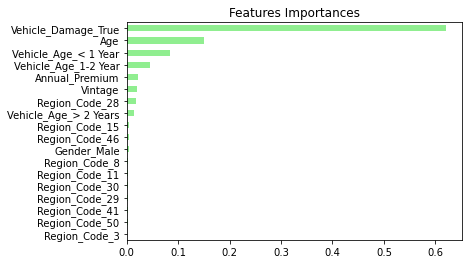

In [18]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf_clf.feature_importances_,
                        index= x_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

### Performance of random forest on training set

In [19]:
#x_train, x_test, y_train, y_test

rf_clf.fit(x_train,y_train)
pred = rf_clf.predict(x_train)
print(classification_report(y_train, pred))
y_score = rf_clf.predict_proba(x_train)[:,1]
confu_mat_rf = confusion_matrix(y_train, pred)
print(confu_mat_rf)
print('\n')
print('Area under curve:', roc_auc_score(y_train, y_score))

              precision    recall  f1-score   support

           0       0.99      0.65      0.79      6506
           1       0.29      0.95      0.45       994

    accuracy                           0.69      7500
   macro avg       0.64      0.80      0.62      7500
weighted avg       0.90      0.69      0.74      7500

[[4246 2260]
 [  51  943]]


Area under curve: 0.8628070296973975


### Performance of random forest on validation set

From the confusion matrix, it looked like the random forest classifier was able to pick out most of the positives correctly (287) on the validation set. However, this came at a cost of performing poorly on 

The AUC score is 0.815 on validation set

In [20]:
#x_train, x_test, y_train, y_test

rf_clf.fit(x_train,y_train)
pred = rf_clf.predict(x_test)
print(classification_report(y_test, pred))
y_score = rf_clf.predict_proba(x_test)[:,1]
confu_mat_rf = confusion_matrix(y_test, pred)
print(confu_mat_rf)
print('\n')
print('Area under curve:', roc_auc_score(y_test, y_score))

              precision    recall  f1-score   support

           0       0.98      0.64      0.78      2168
           1       0.29      0.93      0.44       332

    accuracy                           0.68      2500
   macro avg       0.63      0.79      0.61      2500
weighted avg       0.89      0.68      0.73      2500

[[1393  775]
 [  23  309]]


Area under curve: 0.8154266049437603


ROC, AUC score

### Performance of random forest on test-set

AUC score 0.818 for RandomForestClassifier on test set. Similarly, it managed to classify many of the True Positives well, but at the cost of classifying relatively large proportion of False Positives.

In [21]:
rf_clf.fit(train_cov,train_target)
pred = rf_clf.predict(test_cov)
print(classification_report(test_target, pred))
y_score = rf_clf.predict_proba(test_cov)[:,1]
confu_mat_rf = confusion_matrix(test_target, pred)
print(confu_mat_rf)
print('\n')
print('Area under curve:', roc_auc_score(test_target, y_score))

              precision    recall  f1-score   support

           0       0.98      0.64      0.77      8636
           1       0.28      0.91      0.43      1364

    accuracy                           0.67     10000
   macro avg       0.63      0.77      0.60     10000
weighted avg       0.88      0.67      0.72     10000

[[5499 3137]
 [ 125 1239]]


Area under curve: 0.8179244219451005


# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score,classification_report 

# Initiate Logistic Regression classifier

param_grid = {'C': [0.001, 0.05, 0.01, 0.05, 0.1, 0.25, 0.5, 1, 5, 10, 15, 50, 100, 1000],
             'class_weight':["balanced", "balanced_subsample",None]}
lr_random = GridSearchCV(estimator = LogisticRegression(), 
                               param_grid = param_grid,
                               scoring = 'roc_auc',
                               #n_iter = n_models, 
                               cv = 5, 
                               n_jobs = -1,
                              return_train_score = True)
lr_random.fit(x_train, y_train)
print(lr_random.best_params_)

LR = LogisticRegression(C = 0.25,class_weight= 'balanced') 
LR.fit(train_cov,train_target)

{'C': 0.25, 'class_weight': 'balanced'}


LogisticRegression(C=0.5, class_weight='balanced')

In [23]:
# print out coefficients in a table
pd.DataFrame(zip(x_train.columns, np.transpose(LR.coef_.tolist()[0])), columns=['features', 'coef'])

,features,coef
0,Age,-0.365379
1,Annual_Premium,-0.266777
2,Vintage,-0.001713
3,Region_Code_3,0.016063
4,Region_Code_8,-0.164416
5,Region_Code_11,0.590630
6,Region_Code_15,-0.552953
7,Region_Code_28,0.148800
8,Region_Code_29,0.255363
9,Region_Code_30,-0.020248


### Performance of Logistic Regression on training-set

In [24]:
LR.fit(x_train,y_train)
pred = LR.predict(x_train)
print(classification_report(y_train, pred))
y_score = LR.predict_proba(x_train)[:,1]
confu_mat_lr = confusion_matrix(y_train, pred)
print(confu_mat_lr)
print('\n')
print('Area under curve:', roc_auc_score(y_train, y_score))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75      6506
           1       0.27      0.96      0.42       994

    accuracy                           0.65      7500
   macro avg       0.63      0.78      0.58      7500
weighted avg       0.89      0.65      0.70      7500

[[3887 2619]
 [  39  955]]


Area under curve: 0.823760268342301


### Performance of Logistic Regression on validation-set

The AUC score of Logistic Regression is 0.817. However, it managed to classify True Positives better with a larger number of True Positives than Random Forest.

In [25]:
#x_train, x_test, y_train, y_test

LR.fit(x_train,y_train)
pred = LR.predict(x_test)
print(classification_report(y_test, pred))
y_score = LR.predict_proba(x_test)[:,1]
confu_mat_lr = confusion_matrix(y_test, pred)
print(confu_mat_lr)
print('\n')
print('Area under curve:', roc_auc_score(y_test, y_score))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      2168
           1       0.26      0.96      0.41       332

    accuracy                           0.64      2500
   macro avg       0.63      0.77      0.58      2500
weighted avg       0.89      0.64      0.70      2500

[[1277  891]
 [  14  318]]


Area under curve: 0.8165387565020228


### Performance of Logistic Regression on test-set

The AUC score of Logistic Regression is 0.818, on test set.

In [26]:
# test_target are actual Y from Prof test set
# test_cov are actual X from Prof test_set

# y_pred are predictions of labels made by model for each observation, given covariates
# y_probs are the probability of each observation's label = 1
# this model predicted all test labels to be 0

LR.fit(train_cov,train_target)
y_pred = LR.predict(test_cov)
y_probs= LR.predict_proba(test_cov)[:,1] # this assumes threshold to be 0.5. need to modify threshold

# print score
print(LR.score(test_cov, test_target))

# print accuracy score
acc = accuracy_score(test_target, y_pred)
print("accuracy score :", acc)

# print roc accuracy score
roc  = roc_auc_score(test_target, y_probs)
print("roc_auc score :", roc)

# print confusion matrix
confu_mat = confusion_matrix(test_target, y_pred)
print("confusion matrix :", confu_mat)

print(classification_report(test_target, y_pred))

0.6342
accuracy score : 0.6342
roc_auc score : 0.8183249905938315
confusion matrix : [[5048 3588]
 [  70 1294]]
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      8636
           1       0.27      0.95      0.41      1364

    accuracy                           0.63     10000
   macro avg       0.63      0.77      0.57     10000
weighted avg       0.89      0.63      0.69     10000



# Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score,classification_report 

# Instantiate a DecisionTreeClassifier 'dt'
dt = DecisionTreeClassifier(random_state=1)
                            
#Define grid of hyperparams'params_dt'
params_dt = {
            'max_depth': [3, 4, 5, 6, 7, 8], 
            'min_samples_leaf': [0.04, 0.06, 0.08, 0.10, 0.12], 
            'max_features': ['auto', 'sqrt', 'log2'],
            'class_weight': ["balanced", "balanced_subsample",None]
            }

# Instantiate a 5-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv = 5, 
                       n_jobs = -1,
                       return_train_score = True)

grid_dt.fit(x_train, y_train)
print('Best hyperparameters:\n', grid_dt.best_params_)

dt = DecisionTreeClassifier(max_depth = 5,
                           max_features = 'auto',
                           min_samples_leaf = 0.04,
                           class_weight = 'balanced')

Best hyperparameters:
 {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 0.04}


### Performance of Decision Tree on training-set

In [56]:
dt.fit(x_train,y_train)
pred = dt.predict(x_train)
print(classification_report(y_train, pred))
y_score = dt.predict_proba(x_train)[:,1]
confu_mat_dt = confusion_matrix(y_train, pred)
print(confu_mat_dt)
print('\n')
print('Area under curve:', roc_auc_score(y_train, y_score))

              precision    recall  f1-score   support

           0       0.95      0.63      0.76      6506
           1       0.24      0.77      0.37       994

    accuracy                           0.65      7500
   macro avg       0.59      0.70      0.56      7500
weighted avg       0.85      0.65      0.71      7500

[[4102 2404]
 [ 226  768]]


Area under curve: 0.7448651330052247


### Performance of Decision Tree on validation set

The decision tree in classifying number of True Positives, outperformed the Random Forest and Logistic Regression classifiers

The AUC score for decision tree is 0.780

Generally, the AUC scores for the 3 models were pretty even, with  the Decision Tree slightly better than Logistic Regression.

In [50]:
#x_train, x_test, y_train, y_test
dt.fit(x_train,y_train)
pred = dt.predict(x_test)
print(classification_report(y_test, pred))
y_score = dt.predict_proba(x_test)[:,1]
confu_mat_dt = confusion_matrix(y_test, pred)
print(confu_mat_dt)
print('\n')
print('Area under curve:', roc_auc_score(y_test, y_score))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      2168
           1       0.27      0.96      0.42       332

    accuracy                           0.64      2500
   macro avg       0.63      0.78      0.58      2500
weighted avg       0.89      0.64      0.70      2500

[[1289  879]
 [  13  319]]


Area under curve: 0.779762037078202


### Performance of Decision Tree on test-set

However the Decision Tree performed extremely poorly on the test set, which suffered from the issue of imbalanced classes. At a 0.5 threshold, it classfied all test observations' labels to be negative, meaning it failed to even classify even 1 of the test observations' correctly, despite the high accuracy score of 0.86, with the auc score at 0.797

In [51]:
dt.fit(train_cov, train_target)
dt_y_pred = dt.predict(test_cov)
dt_y_proba = dt.predict_proba(test_cov)[:, 1]

#print accuracy score
print('accuracy score:', accuracy_score(dt_y_pred, test_target))

#print roc accuracy score
print('roc auc score:', roc_auc_score(test_target, dt_y_proba))

#print confumtx
print('confusion matrix:\n', confusion_matrix(test_target, dt_y_pred))

print(classification_report(test_target, dt_y_pred))

accuracy score: 0.6611
roc auc score: 0.7965561198502077
confusion matrix:
 [[5363 3273]
 [ 116 1248]]
              precision    recall  f1-score   support

           0       0.98      0.62      0.76      8636
           1       0.28      0.91      0.42      1364

    accuracy                           0.66     10000
   macro avg       0.63      0.77      0.59     10000
weighted avg       0.88      0.66      0.71     10000



# Q1

# Q2

Note that for question 2 and 3, our model uses the training and validation sets, not the test sets (*test_cov* and *test_target*)

In [31]:
threshold_list = [0.01,0.1,0.2,0.5]
tp_list = []
fp_list = [] 
tp_rate_list = []
fp_rate_list = []

LR.fit(x_train,y_train)

for i in threshold_list:
    print ('\n******** For threshold = {} ******'.format(i))
    decisions = (LR.predict_proba(x_test)[:,1] >= i).astype(int)
    cm = confusion_matrix(y_test, decisions)
    print("confusion matrix :", cm)
    
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    print(TN)
    print(FN)
    print(TP)
    print(FP)

    benefit_structure = (TP*10) + (FN*-10) + (FP*-2) + ((TP+FP)*-1)
    print("benefit:", benefit_structure)
    tp_rate = (TP)/(TP + FN)
    fp_rate = (FP)/(FP + TN)
    print("True Positive Rate:", tp_rate)
    print("False Positive Rate", fp_rate)
    fp_list.append(FP)
    tp_list.append(TP)
    tp_rate_list.append(tp_rate)
    fp_rate_list.append(fp_rate)
    
print('\n****************')
print('True Positive List:' ,tp_list, '\n')
print('False Positive List:' ,fp_list, '\n')

print('\n****************')
print('True Positive Rate List:' ,tp_rate_list, '\n')
print('False Positive Rate List:' ,fp_rate_list, '\n')


******** For threshold = 0.01 ******
confusion matrix : [[   0 2168]
 [   0  332]]
0
0
332
2168
benefit: -3516
True Positive Rate: 1.0
False Positive Rate 1.0

******** For threshold = 0.1 ******
confusion matrix : [[1196  972]
 [   7  325]]
1196
7
325
972
benefit: -61
True Positive Rate: 0.9789156626506024
False Positive Rate 0.4483394833948339

******** For threshold = 0.2 ******
confusion matrix : [[1196  972]
 [   7  325]]
1196
7
325
972
benefit: -61
True Positive Rate: 0.9789156626506024
False Positive Rate 0.4483394833948339

******** For threshold = 0.5 ******
confusion matrix : [[1277  891]
 [  14  318]]
1277
14
318
891
benefit: 49
True Positive Rate: 0.9578313253012049
False Positive Rate 0.4109778597785978

****************
True Positive List: [332, 325, 325, 318] 

False Positive List: [2168, 972, 972, 891] 


****************
True Positive Rate List: [1.0, 0.9789156626506024, 0.9789156626506024, 0.9578313253012049] 

False Positive Rate List: [1.0, 0.4483394833948339, 0.44

## Plot ROC-AUC curve

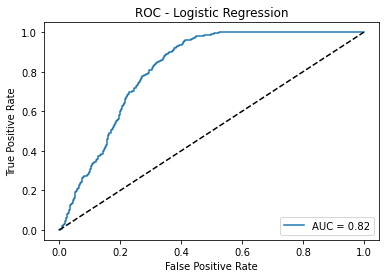

Area under curve (AUC):  0.8165387565020228


In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
probs = LR.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.title('ROC - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot(fpr,tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))



# Q3

In [33]:
threshold_list = [0.01,0.1,0.2,0.5]
tp_list = []
fp_list = [] 
tp_rate_list = []
fp_rate_list = []

for i in threshold_list:
    print ('\n******** For threshold = {} ******'.format(i))
    decisions = (LR.predict_proba(x_test)[:,1] >= i).astype(int)
    cm = confusion_matrix(y_test, decisions)
    print("confusion matrix :", cm)
    
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

    benefit_structure = (TP*100) + (FN*-100) + (FP*-2) + ((TP+FP)*-1)
    print("benefit:", benefit_structure)
    tp_rate = (TP)/(TP + FN)
    fp_rate = (FP)/(FP + TN)
    print("True Positive Rate:", tp_rate)
    print("False Positive Rate", fp_rate)
    fp_list.append(FP)
    tp_list.append(TP)
    tp_rate_list.append(tp_rate)
    fp_rate_list.append(fp_rate)
    
print('\n****************')
print('True Positive List:' ,tp_list, '\n')
print('False Positive List:' ,fp_list, '\n')

print('\n****************')
print('True Positive Rate List:' ,tp_rate_list, '\n')
print('False Positive Rate List:' ,fp_rate_list, '\n')


******** For threshold = 0.01 ******
confusion matrix : [[   0 2168]
 [   0  332]]
benefit: 26364
True Positive Rate: 1.0
False Positive Rate 1.0

******** For threshold = 0.1 ******
confusion matrix : [[1196  972]
 [   7  325]]
benefit: 28559
True Positive Rate: 0.9789156626506024
False Positive Rate 0.4483394833948339

******** For threshold = 0.2 ******
confusion matrix : [[1196  972]
 [   7  325]]
benefit: 28559
True Positive Rate: 0.9789156626506024
False Positive Rate 0.4483394833948339

******** For threshold = 0.5 ******
confusion matrix : [[1277  891]
 [  14  318]]
benefit: 27409
True Positive Rate: 0.9578313253012049
False Positive Rate 0.4109778597785978

****************
True Positive List: [332, 325, 325, 318] 

False Positive List: [2168, 972, 972, 891] 


****************
True Positive Rate List: [1.0, 0.9789156626506024, 0.9789156626506024, 0.9578313253012049] 

False Positive Rate List: [1.0, 0.4483394833948339, 0.4483394833948339, 0.4109778597785978] 

